In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import glob
import imageio
import PIL
from IPython import display
import time
import random

In [2]:
train_armed = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weaponandnorm/train/train',
    image_size=(256, 256), 
    batch_size=32,
    shuffle=True
)
val_armed = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weaponandnorm/test/test',
    image_size=(256, 256), 
    batch_size=32,
    shuffle=True
)

train_weapons = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weapondetection/Weapons',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256), 
    batch_size=32,
    shuffle=True
)

val_weapons = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/weapondetection/Weapons',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256), 
    batch_size=32,
    shuffle=True
)


Found 1513 files belonging to 2 classes.
Found 456 files belonging to 2 classes.
Found 8093 files belonging to 2 classes.
Using 6475 files for training.
Found 8093 files belonging to 2 classes.
Using 1618 files for validation.


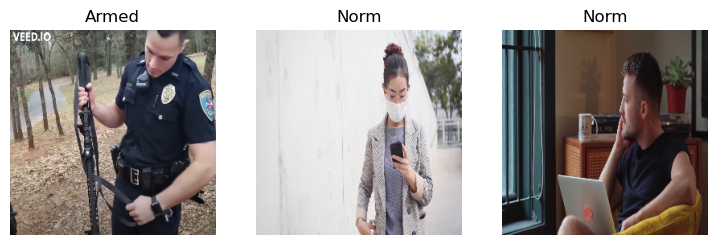

In [5]:
class_names = ['Norm', 'Armed']

fig = plt.figure(figsize=(9, 12))
for image, label in train_armed.take(1):
  for i in range(3):
    print()
    plt.subplot(1, 3, i + 1)
    plt.imshow((image[i]).numpy().astype('int32'))
    plt.title(class_names[label[i].numpy()])
    plt.axis('off')

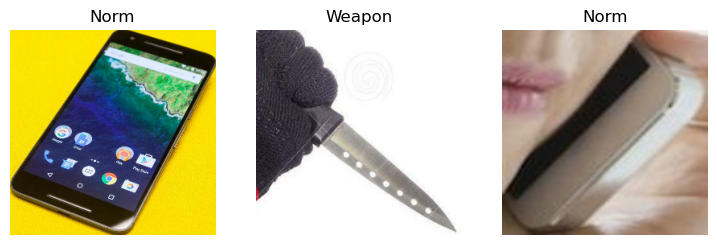

In [6]:
class_names = ['Norm', 'Weapon']

fig = plt.figure(figsize=(9, 12))
for image, label in train_weapons.take(1):
  for i in range(3):
    print()
    plt.subplot(1, 3, i + 1)
    plt.imshow((image[i]).numpy().astype('int32'))
    plt.title(class_names[label[i].numpy()])
    plt.axis('off')

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_armed = train_armed.cache().prefetch(buffer_size=AUTOTUNE)
val_armed = val_armed.cache().prefetch(buffer_size=AUTOTUNE)
train_armed = train_armed.map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y))
val_armed = val_armed.map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y))

train_weapons = train_weapons.cache().prefetch(buffer_size=AUTOTUNE)
val_weapons = val_weapons.cache().prefetch(buffer_size=AUTOTUNE)
train_weapons = train_weapons.map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y))
val_weapons = val_weapons.map(lambda x, y: (tf.keras.layers.Rescaling(1./127.5, offset=-1)(x), y))

In [4]:
optimizer = tf.keras.optimizers.Adam()

entropy = tf.keras.losses.BinaryCrossentropy()

metric = tf.keras.metrics.BinaryAccuracy()

In [5]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = { 
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout]
}

In [6]:
def basic_block(x, filter, stride):
  input = x

  x = layers.Conv2D(filter, 3, stride, padding='same', kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filter, 3, 1, padding='same', kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  
  if stride != 1:
    input = layers.Conv2D(filter, 1, 2, padding='same', kernel_initializer="he_normal")(input)
    input = layers.BatchNormalization()(input)

  x = layers.Add()([x, input])
  x = layers.ReLU()(x)

  return x

In [7]:
def resnet18():

  input = layers.Input((256, 256, 3))
  x = layers.ZeroPadding2D((3, 3))(input)
  x = layers.Conv2D(64, 7, 2, padding='same', kernel_initializer="he_normal")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPool2D(3, 2, padding='same')(x)

  num_blocks = [2, 2, 2, 2]
  filter = 64
  for i in range(len(num_blocks)):
    for j in range(num_blocks[i]):
      x = basic_block(x, filter, [2, 1][i == 0])
    filter *= 2

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(inputs = input, outputs = x, name = "ResNet18")
  return model


classifier = resnet18()
classifier.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 131, 131, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [8]:
class ResNet18(Model):

  def __init__(self, classifier, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.classifier = classifier
    self.weight = 0.6

  def compile(self, optimizer, entropy, metric, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.optimizer = optimizer
    self.loss = entropy
    self.val_acc_metric = metric

  def train_step(self, data):

    (armed, armed_labels), (weapon, weapon_labels) = data
    

    with tf.GradientTape() as cls_armed_tape:
    
      armed = DiffAugment(armed, policy='color,translation,cutout')

      armed_prediction = self.classifier(armed, training=True)

      armed_loss = self.loss(armed_labels, armed_prediction)

    gradients_of_classifier_armed = cls_armed_tape.gradient(armed_loss, self.classifier.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients_of_classifier_armed, self.classifier.trainable_variables))

    with tf.GradientTape() as cls_weapons_tape:
    
      weapon = DiffAugment(weapon, policy='color,translation,cutout')

      weapon_prediction = self.classifier(weapon, training=True)

      weapon_loss = self.weight * self.loss(weapon_labels, weapon_prediction)

    gradients_of_classifier_weapon = cls_weapons_tape.gradient(weapon_loss, self.classifier.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients_of_classifier_weapon, self.classifier.trainable_variables))

    return {'c_loss': armed_loss + weapon_loss} 

  def test_step(self, data):

    real_images, real_labels = data

    prediction = self.classifier(real_images, training=False)

    val_loss = self.loss(real_labels, prediction)

    self.val_acc_metric.update_state(real_labels, prediction)

    return {'loss': val_loss, 'acc': self.val_acc_metric.result()}

In [10]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoints/resnet18.{epoch:03d}',
    save_weights_only=True
)

In [11]:
model = ResNet18(classifier)
model.compile(optimizer, entropy, metric)
hist = model.fit(
    tf.data.Dataset.zip((train_armed, train_weapons)), 
    validation_data=val_weapons, 
    epochs=100,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
48/48 [==============================] - 84s 1s/step - c_loss: 1.1551 - val_loss: 0.4260 - val_acc: 0.8084
Epoch 2/100
48/48 [==============================] - 14s 274ms/step - c_loss: 1.0199 - val_loss: 0.3404 - val_acc: 0.8146
Epoch 3/100
48/48 [==============================] - 14s 279ms/step - c_loss: 0.9418 - val_loss: 0.6752 - val_acc: 0.4685
Epoch 4/100
48/48 [==============================] - 13s 269ms/step - c_loss: 0.9302 - val_loss: 1.4014 - val_acc: 0.3826
Epoch 5/100
48/48 [==============================] - 14s 277ms/step - c_loss: 0.8903 - val_loss: 0.2525 - val_acc: 0.8189
Epoch 6/100
48/48 [==============================] - 13s 271ms/step - c_loss: 0.8461 - val_loss: 0.5559 - val_acc: 0.7132
Epoch 7/100
48/48 [==============================] - 14s 274ms/step - c_loss: 0.8433 - val_loss: 0.7327 - val_acc: 0.5111
Epoch 8/100
48/48 [==============================] - 14s 277ms/step - c_loss: 0.7757 - val_loss: 0.5382 - val_acc: 0.6638
Epoch 9/100
48/48 [========

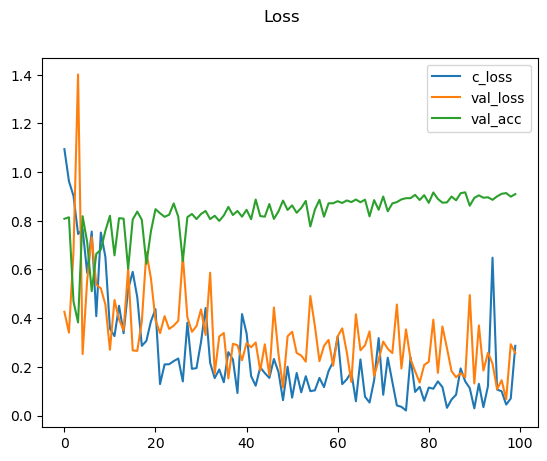

In [12]:
plt.suptitle('Loss')
plt.plot(hist.history['c_loss'], label='c_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [13]:
model.evaluate(val_weapons)

51/51 [==============================] - 2s 33ms/step - loss: 0.2474 - acc: 0.9105


[0.9097651243209839, 0.25650277733802795]